## Importing files

In [141]:
# Importing requiered libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import utils.helpers

# Reload the functions module
importlib.reload(utils.helpers)

<module 'utils.helpers' from 's:\\Courses\\Data Science\\0. Henry\\M7 - Labs - Project MLOps\\recommendation-system-movies-similarity-and-rating\\EDA\\utils\\helpers.py'>

In [142]:
# Importing eda_movies_data.csv file
dataset_path = "data\eda_movies_data.csv"

# Setting low_memory=False - To read the entire file so it determines the data types accurately. 
# Note: It can increase memory usage for larger datasets
info_movies = pd.read_csv(dataset_path, low_memory=False)

In [143]:
info_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45346 entries, 0 to 45345
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45346 non-null  int64  
 1   title              45346 non-null  object 
 2   collection_name    4485 non-null   object 
 3   movie_genres       45346 non-null  object 
 4   release_date       45346 non-null  object 
 5   release_year       45346 non-null  int64  
 6   status             45266 non-null  object 
 7   return             45346 non-null  float64
 8   revenue            45346 non-null  float64
 9   budget             45346 non-null  int64  
 10  vote_count         45346 non-null  float64
 11  vote_average       45346 non-null  float64
 12  popularity         45346 non-null  float64
 13  original_language  45335 non-null  object 
 14  overview           44405 non-null  object 
 15  companies_name     45346 non-null  object 
 16  prod_countries     453

## Data Analysis

## Data Preparation

### Extracting necessary information

In [154]:
#data_for_analysis = info_movies[["id", "title", "movie_genres", "release_year", "status", "return", "budget", "revenue", "vote_count", "vote_average", "popularity"]]
data_for_analysis = info_movies.copy()

In [155]:
data_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45346 entries, 0 to 45345
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45346 non-null  int64  
 1   title              45346 non-null  object 
 2   collection_name    4485 non-null   object 
 3   movie_genres       45346 non-null  object 
 4   release_date       45346 non-null  object 
 5   release_year       45346 non-null  int64  
 6   status             45266 non-null  object 
 7   return             45346 non-null  float64
 8   revenue            45346 non-null  float64
 9   budget             45346 non-null  int64  
 10  vote_count         45346 non-null  float64
 11  vote_average       45346 non-null  float64
 12  popularity         45346 non-null  float64
 13  original_language  45335 non-null  object 
 14  overview           44405 non-null  object 
 15  companies_name     45346 non-null  object 
 16  prod_countries     453

### Data cleaning

#### Delete movies that have empty date values

In [156]:
# Checking the data type
utils.helpers.get_column_summary(data_for_analysis, "release_year")

(release_year
 <class 'int'>    45346
 Name: count, dtype: int64,
 'total values:',
 45346)

In [157]:
# Checking the number of values that have a 0 value in year 
count = 0
for year in data_for_analysis["release_year"]:
    if year == 0:
        count += 1
print(count)

0


#### Delete movies that aren't released yet

In [158]:
# Checking movies that aren't released yet
not_released = []
for idx, (status_value, id_movie) in enumerate(zip(data_for_analysis["status"], data_for_analysis["id"])):
    if status_value != "Released":
        not_released.append(id_movie)

print(len(not_released))

439


In [159]:
# Having only 439 values without status, and bieng less than 1% of the total values
# Deleting the values from the dataset
data_for_analysis_1 = data_for_analysis.copy()

for idx, id_movie_value in enumerate(data_for_analysis_1["id"]):
    if id_movie_value in not_released:
        data_for_analysis_1.drop(idx, inplace=True)


In [160]:
data_for_analysis_1.drop("status", axis=1, inplace=True)


In [ ]:
data_for_analysis_1.info()

#### "vote count" data

In [164]:
# Calculate summary statistics
outliers_st_summary = data_for_analysis_1['vote_count'].describe()

# Print the summary statistics
print(outliers_st_summary)

# Extract individual statistics
outl_mean = outliers_st_summary['mean']
outl_median = outliers_st_summary['50%']  # Median
outl_std_dev = outliers_st_summary['std']
outl_minimum = outliers_st_summary['min']
outl_maximum = outliers_st_summary['max']
outl_q1 = outliers_st_summary['25%']  # First quartile
outl_q3 = outliers_st_summary['75%']  # Third quartile

# Analyze the range of values
outl_range_values = outl_maximum - outl_minimum

count    44907.000000
mean       111.116663
std        494.189808
min          0.000000
25%          3.000000
50%         10.000000
75%         35.000000
max      14075.000000
Name: vote_count, dtype: float64


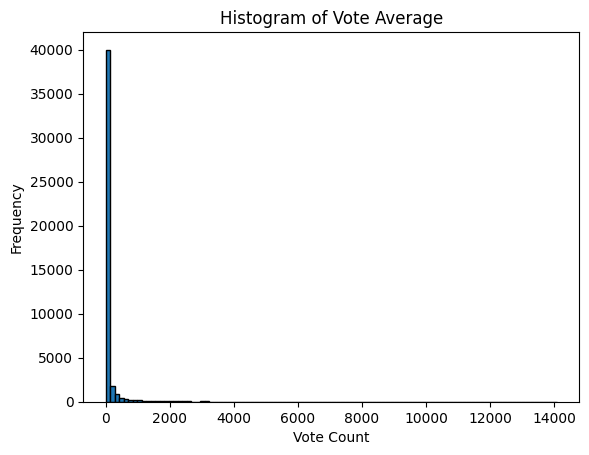

In [169]:
# Plotting the histogram
plt.hist(data_for_analysis_1['vote_count'], bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Histogram of Vote Average')

# Displaying the histogram
plt.show()

In [200]:
# Deleting values with 0 vote count and 0 vote average
# That will mean that it didn't have any entry data

null_vote_values = []
for idx_row, (value_vote_count, value_vote_average) in enumerate(zip(data_for_analysis_1["vote_count"], data_for_analysis_1["vote_average"])):
    if value_vote_count == 0 and value_vote_average == 0:
        null_vote_values.append(idx_row)


data_for_analysis_2 = pd.DataFrame(columns=data_for_analysis_1.columns)
##### ***** PENDING

for index, row in data_for_analysis_1.iterrows():
    if row['id'] not in null_vote_values:
        data_for_analysis_2 = pd.concat([data_for_analysis_2, row.to_frame().T])

# Reset the index of dataset_2
data_for_analysis_2.reset_index(drop=True, inplace=True)

print("Number of null values deleted: ", len(null_vote_values))

,id,title,collection_name,movie_genres,release_date,release_year,return,revenue,budget,vote_count,...,original_language,overview,companies_name,prod_countries,runtime,sp_languages,tagline,actor_name,crew_name,crew_job


#### Outliers in "vote average" column

In [162]:
# Calculate summary statistics
outliers_st_summary = data_for_analysis_1['vote_average'].describe()

# Print the summary statistics
print(outliers_st_summary)

# Extract individual statistics
outl_mean = outliers_st_summary['mean']
outl_median = outliers_st_summary['50%']  # Median
outl_std_dev = outliers_st_summary['std']
outl_minimum = outliers_st_summary['min']
outl_maximum = outliers_st_summary['max']
outl_q1 = outliers_st_summary['25%']  # First quartile
outl_q3 = outliers_st_summary['75%']  # Third quartile

# Analyze the range of values
outl_range_values = outl_maximum - outl_minimum

count    44907.000000
mean         5.629563
std          1.907376
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64


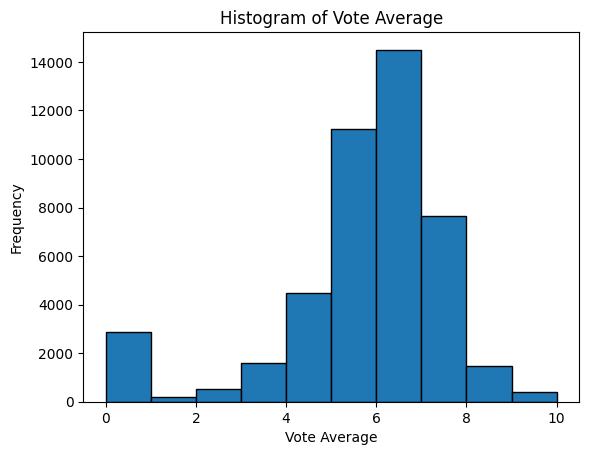

In [163]:
# Plotting the histogram
plt.hist(data_for_analysis_1['vote_average'], bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.title('Histogram of Vote Average')

# Displaying the histogram
plt.show()

#### Outliers in "return" column

In [152]:
# Calculate summary statistics
outliers_st_summary = data_for_analysis_1['return'].describe()

# Print the summary statistics
print(outliers_st_summary)

# Extract individual statistics
outl_mean = outliers_st_summary['mean']
outl_median = outliers_st_summary['50%']  # Median
outl_std_dev = outliers_st_summary['std']
outl_minimum = outliers_st_summary['min']
outl_maximum = outliers_st_summary['max']
outl_q1 = outliers_st_summary['25%']  # First quartile
outl_q3 = outliers_st_summary['75%']  # Third quartile

# Analyze the range of values
outl_range_values = outl_maximum - outl_minimum

count    4.490700e+04
mean     6.669357e+02
std      7.508230e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.239638e+07
Name: return, dtype: float64


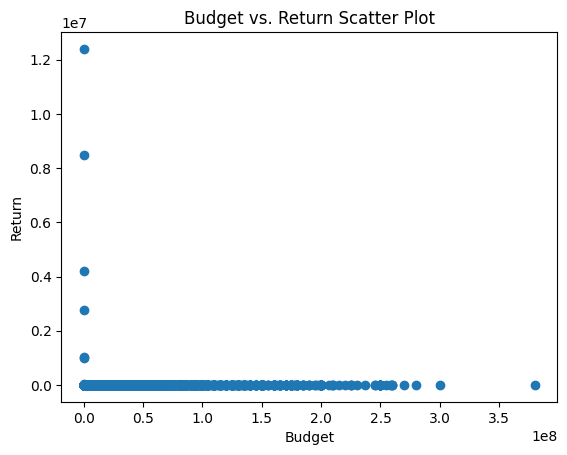

In [153]:
# Scatter plot
plt.scatter(data_for_analysis_1['budget'], data_for_analysis_1['return'])

# Set labels and title
plt.xlabel('Budget')
plt.ylabel('Return')
plt.title('Budget vs. Return Scatter Plot')

# Show the plot
plt.show()

The majority of the return values are very close to 0. The mean and standard deviation are heavily influenced by the extreme maximum value, which is significantly larger than the other values as can be seen in the graph above

Deleting outliers from return

In [136]:
data_for_analysis_2 = data_for_analysis_1.copy()

In [138]:
# Checking return values greater than 0.1
return_outl_values = []
for idx, (return_value, id_movie) in enumerate(zip(data_for_analysis_2["return"], data_for_analysis_2["id"])):
    if return_value > 0.1:
        return_outl_values.append(id_movie)

print(len(return_outl_values))

5041


In [ ]:
# Having only 439 values without status, and bieng less than 1% of the total values
# Deleting the values from the dataset
for idx, id_movie_value in enumerate(data_for_analysis_2["id"]):
    if id_movie_value in return_outl_values:
        try:
            data_for_analysis_2.drop(idx, inplace=True)
        except (ValueError):
            pass


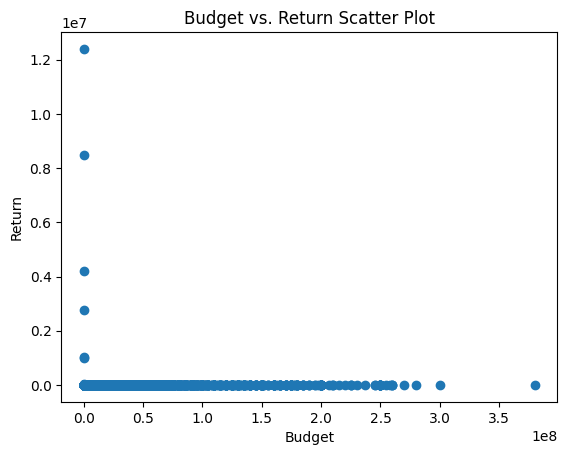

In [ ]:
# Scatter plot
plt.scatter(data_for_analysis_2['budget'], data_for_analysis_2['return'])

# Set labels and title
plt.xlabel('Budget')
plt.ylabel('Return')
plt.title('Budget vs. Return Scatter Plot')

# Show the plot
plt.show()

After analysis

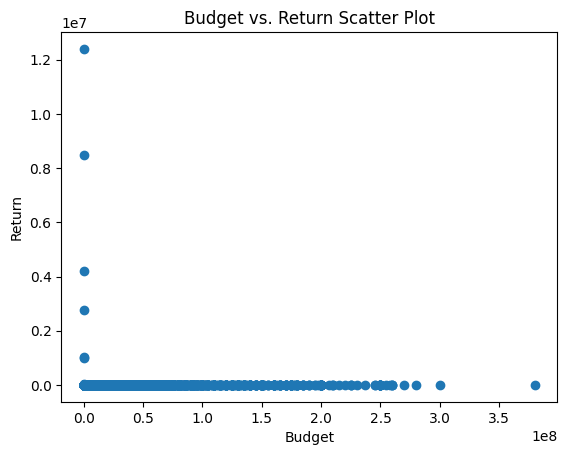

In [124]:
# Scatter plot
plt.scatter(data_for_analysis_2['budget'], data_for_analysis_2['return'])

# Set labels and title
plt.xlabel('Budget')
plt.ylabel('Return')
plt.title('Budget vs. Return Scatter Plot')

# Show the plot
plt.show()